In [1]:
# this notebook will be used for 
# 1. examining the BglB data set for expression 
# 2. training classifiers on BglB data set (speculative targets)
# 3. assessing performance of classifiers 
# and anthre book will be used for predictions across family based on this trained model 

In [2]:
import pandas 
from sklearn import preprocessing, svm, ensemble, model_selection, metrics, manifold, decomposition
import pyrosetta 
from rosetta import protocols, core 
from Bio.Data import IUPACData
import matplotlib.pyplot as plt 
import numpy as np 
%matplotlib inline

plt.style.available

['ggplot',
 'seaborn-colorblind',
 'bmh',
 'seaborn',
 'classic',
 'grayscale',
 'seaborn-bright',
 'seaborn-poster',
 'seaborn-notebook',
 'seaborn-white',
 'dark_background',
 'seaborn-pastel',
 'seaborn-darkgrid',
 'seaborn-muted',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-dark',
 'seaborn-deep',
 'seaborn-whitegrid',
 'seaborn-talk',
 'seaborn-paper',
 'seaborn-dark-palette']

In [3]:
plt.style.use('seaborn-deep')

In [4]:
pyrosetta.init('-beta')

Found rosetta database at: /Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/pyrosetta-4.0-py3.5.egg/database; using it....
PyRosetta-4 2016 [Rosetta 2016 unknown:94998f0e5b038b6d8083995a664cb96641cb844b 2017-05-11 15:10:16 -0500] retrieved from: git@github.com:RosettaCommons/main.git
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.



In [5]:
df = pandas.read_csv('../data_sets/speculative_targets.csv', index_col=0)
df.drop('BglB', axis=0, inplace=True)
df.sample(5)

kcat        km    kcatkm  expression
mutant_name                                          
K413A       -0.175401 -0.283997  0.113559           1
V320Q        0.114171  0.133539 -0.014404           1
W120A             NaN       NaN       NaN           0
M261D             NaN       NaN       NaN           0
T352A       -1.166331  0.455150 -1.619997           1

In [6]:
df.shape

(145, 4)

In [7]:
# for features, lets use the mutate-only set for now 

In [8]:
p = pyrosetta.pose_from_file('../rosetta_runs/bglb/relax/output/relax_387/2JIE_0001.pdb')
s = pyrosetta.create_score_function('beta_cst')
s(p)

-1396.9818086598987

In [9]:
total_score = core.scoring.score_type_from_name('total_score')
fa_rep = core.scoring.score_type_from_name('fa_rep')

In [10]:
en = p.energies()
en.total_energies()[total_score]

-1396.9818086598987

In [11]:
hood = core.select.residue_selector.NeighborhoodResidueSelector()
hood.set_focus('11')
hood.set_distance(9.23)
hood.apply(p)

vector1_bool[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
cp = p.clone()
holes = protocols.vip.output_packstat(cp)
print(holes)
mutate = protocols.simple_moves.MutateResidue(399, 'ALA')
mutate.apply(cp)
holes = protocols.vip.output_packstat(cp)
print(holes) 

0.677267512846004
0.6658536870512579


In [13]:
en = p.energies()
en.residue_total_energies(10)

In [14]:
# OK, for each mutant, we need a score 

def rosetta_score(score_type='total_score'):
    
    def fetch_residue_scores(pose):
        for n in range(1, pose.total_residue()):
            for m in s.get_nonzero_weighted_scoretypes():
                yield pose.energies().residue_total_energies(n)[m]
    
    score_type = core.scoring.score_type_from_name(score_type)
    for mutant_name in df.index:
        pose = p.clone()
        native, *pos, design = mutant_name 
        pos = int(''.join(pos))
        design = IUPACData.protein_letters_1to3[design].upper()
        mutate = protocols.simple_moves.MutateResidue(pos, design) 
        _ = s(pose)
        #score_begin = [pose.energies().total_energies()[n] for n in s.get_nonzero_weighted_scoretypes()] #WT
        mutate.apply(pose)
        residue_scores = list(fetch_residue_scores(pose)) 
        #print(len(residue_scores))
        #print(residue_scores[0:])
        _ = s(pose) 
        #score_end = [pose.energies().total_energies()[n] for n in s.get_nonzero_weighted_scoretypes()] #WT
        #score_delta = np.array(score_end) - np.array(score_begin) # this will "just work" when these are Numpy arrays
        yield residue_scores  
        
#list_of_score_type_names = [str(n).replace('ScoreType.', '') for n in s.get_nonzero_weighted_scoretypes()]
features = pandas.DataFrame(list(rosetta_score()), index=df.index) #, columns=list_of_score_type_names) 
features.head()

0         1        2         3         4       5      \
mutant_name                                                            
S14A        -0.756657  0.133583  0.87573 -0.329172  0.128504  0.6347   
T15A        -0.756657  0.133583  0.87573 -0.329172  0.128504  0.6347   
S16A        -0.756657  0.133583  0.87573 -0.329172  0.128504  0.6347   
S17A        -0.756657  0.133583  0.87573 -0.329172  0.128504  0.6347   
S17E        -0.756657  0.133583  0.87573 -0.329172  0.128504  0.6347   

                6         7         8         9      ...       14198  14199  \
mutant_name                                          ...                      
S14A         0.079079  1.236898  0.054446  0.560095  ...   -0.147906    0.0   
T15A         0.079079  1.236898  0.054446  0.560095  ...   -0.147906    0.0   
S16A         0.079079  1.236898  0.054446  0.560095  ...   -0.147906    0.0   
S17A         0.079079  1.236898  0.054446  0.560095  ...   -0.147906    0.0   
S17E         0.079079  1.236898  0.054446  0.560095  ...   -0.147906    0.0   

             14200  14201     14202  14203    14204  14205     14206  14207  
mutant_name                                                                  
S14A           0.0    0.0 -2.514574    0.0  0.83697    0.0 -0.179715    0.0  
T15A           0.0    0.0 -2.514574    0.0  0.83697    0.0 -0.179715    0.0  
S16A           0.0    0.0 -2.514574    0.0  0.83697    0.0 -0.179715    0.0  
S17A           0.0    0.0 -2.514574    0.0  0.83697    0.0 -0.179715    0.0  
S17E           0.0    0.0 -2.514574    0.0  0.83697    0.0 -0.179715    0.0  

[5 rows x 14208 columns]

In [15]:
features.shape

(145, 14208)

In [16]:
# clean up features a bit 
drop_me = []
for feature in features:
    if features[feature].std() == 0.0:
        drop_me.append(feature)

features.drop(drop_me, axis=1, inplace=1) 
features.shape

(145, 7311)

**Result: dropping features with `variance == 0.0` reduces feature count from 14208 to 7311**. This leaves sample size (145) unchanged. 

In [17]:
J = df[['expression']].join(features) 
J.head()

expression         0         1        2         3         4  \
mutant_name                                                                
A192S                 1 -0.756657  0.133583  0.87573 -0.329172  0.128504   
A227W                 1 -0.756657  0.133583  0.87573 -0.329172  0.128504   
A236E                 0 -0.756657  0.133583  0.87573 -0.329172  0.128504   
A249E                 0 -0.756657  0.133583  0.87573 -0.329172  0.128504   
C167A                 1 -0.756657  0.133583  0.87573 -0.329172  0.128504   

                  5         6         7         8    ...        14182  \
mutant_name                                          ...                
A192S        0.6347  0.079079  1.236898  0.054446    ...     1.590536   
A227W        0.6347  0.079079  1.236898  0.054446    ...     1.590536   
A236E        0.6347  0.079079  1.236898  0.054446    ...     1.590536   
A249E        0.6347  0.079079  1.236898  0.054446    ...     1.590536   
C167A        0.6347  0.079079  1.236898  0.054446    ...     1.590536   

                14183     14184     14185     14186     14187     14198  \
mutant_name                                                               
A192S        4.453011  0.005192  0.055272 -1.566929 -0.356308 -0.147906   
A227W        4.453011  0.005192  0.055272 -1.566929 -0.356308 -0.147906   
A236E        4.453011  0.005192  0.055272 -1.566929 -0.356308 -0.147906   
A249E        4.453011  0.005192  0.055272 -1.566929 -0.356308 -0.147906   
C167A        4.453011  0.005192  0.055272 -1.566929 -0.356308 -0.147906   

                14202    14204     14206  
mutant_name                               
A192S       -2.514574  0.83697 -0.179715  
A227W       -2.514574  0.83697 -0.179715  
A236E       -2.514574  0.83697 -0.179715  
A249E       -2.514574  0.83697 -0.179715  
C167A       -2.514574  0.83697 -0.179715  

[5 rows x 7312 columns]

In [21]:
from scipy import stats 

We are interested in: for each of the features, is there a significant difference between the feature for proteins that express and proteins that do not express? 

In [25]:
stats.ks_2samp((1, 1, 1), (1, 1, 1))

Ks_2sampResult(statistic=0.0, pvalue=1.0)

In [27]:
for feature in J.columns[1:]:
    ks = stats.ks_2samp(J.query('expression==0')[feature], J.query('expression==1')[feature])
    if ks.statistic > 0.0:
        print(ks)
        print(feature)

In [ ]:
plot = J.columns #['fa_rep', 'fa_atr', 'omega'] 
fig, ax = plt.subplots(nrows=1, ncols=len(plot), figsize=(3*len(plot), 3))
for n, f in enumerate(plot):
    bins = np.linspace(J[f].min(), J[f].max(), 20)
    J[(J.expression==1)].hist(f, color='green', ax=ax[n], bins=bins, alpha=0.5)
    J[(J.expression==0)].hist(f, color='red', ax=ax[n], bins=bins, alpha=0.5)
    ax[n].legend(['yes', 'no'])

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4294)
KeyboardInterrupt


**Analysis of the experimental data**. We have data for 145 proteins, of which about 40 do not express and about 105 do express, making for a slightly unbalanced data set. 

In [348]:
fig, ax = plt.subplots(nrows=1, ncols=2)

tsne = manifold.TSNE()
reduced = tsne.fit_transform(X, y) 
ax[0].scatter(reduced[:, 0], reduced[:, 1], c=y) 
ax[0].set(title='t-SNE', xlabel='Component 1', ylabel='Component 2') 

pca = decomposition.PCA(n_components=2)
reduced = pca.fit_transform(X, y) 
ax[1].scatter(reduced[:, 0], reduced[:, 1], c=y) 
ax[1].set(title='PCA', xlabel='Component 1', ylabel='Component 2')

fig.tight_layout()

**Analysis of the feature decomposition and t-distributed stochastic neighbor embedding**. Features decomposed into dimension of 2 do not appear to be linearly separable. We will have to use a machine learning technique. 

In [305]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(J.iloc[:, 1:])
y = J.iloc[:, 0].ravel()
clf = svm.SVC(C=3, probability=1, class_weight='balanced', kernel='rbf')
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
clf.fit(X_train, y_train) 
pred = clf.predict(X_test)
prob = clf.predict_proba(X_test) 
fpr, tpr, _ = metrics.roc_curve(y_test, prob[:, 1], pos_label=1) 
auc = metrics.roc_auc_score(y_test, prob[:, 1]) 
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('AUC {0:2.2}'.format(auc))

**Machine learning analysis**. We train a RBF-kernel SVM on 70% of the data set, and test on remaining 30%. ROC curve. As a very first look, this is somewhat promising, bordering on 'meh'. 

In [313]:
from sklearn import dummy 

In [321]:
# let's see if we can grid search for a better set of params, and do some CV as well 
clf = svm.SVC(C=10, kernel='rbf')
mean_svm_score, svm_score = model_selection.permutation_test_score(clf, X, y, cv=10, n_jobs=-1) 

clf = dummy.DummyClassifier(strategy='stratified')
mean_dum_score, dum_score = model_selection.permutation_test_score(clf, X, y, cv=10, n_jobs=-1)

ValueError: too many values to unpack (expected 2)

In [ ]:
fig, ax = plt.subplots()
svm_score

In [308]:
real_data = (tsne.fit_transform(X), y) 

/Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/alex/anaconda3/envs/rose/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), Converge

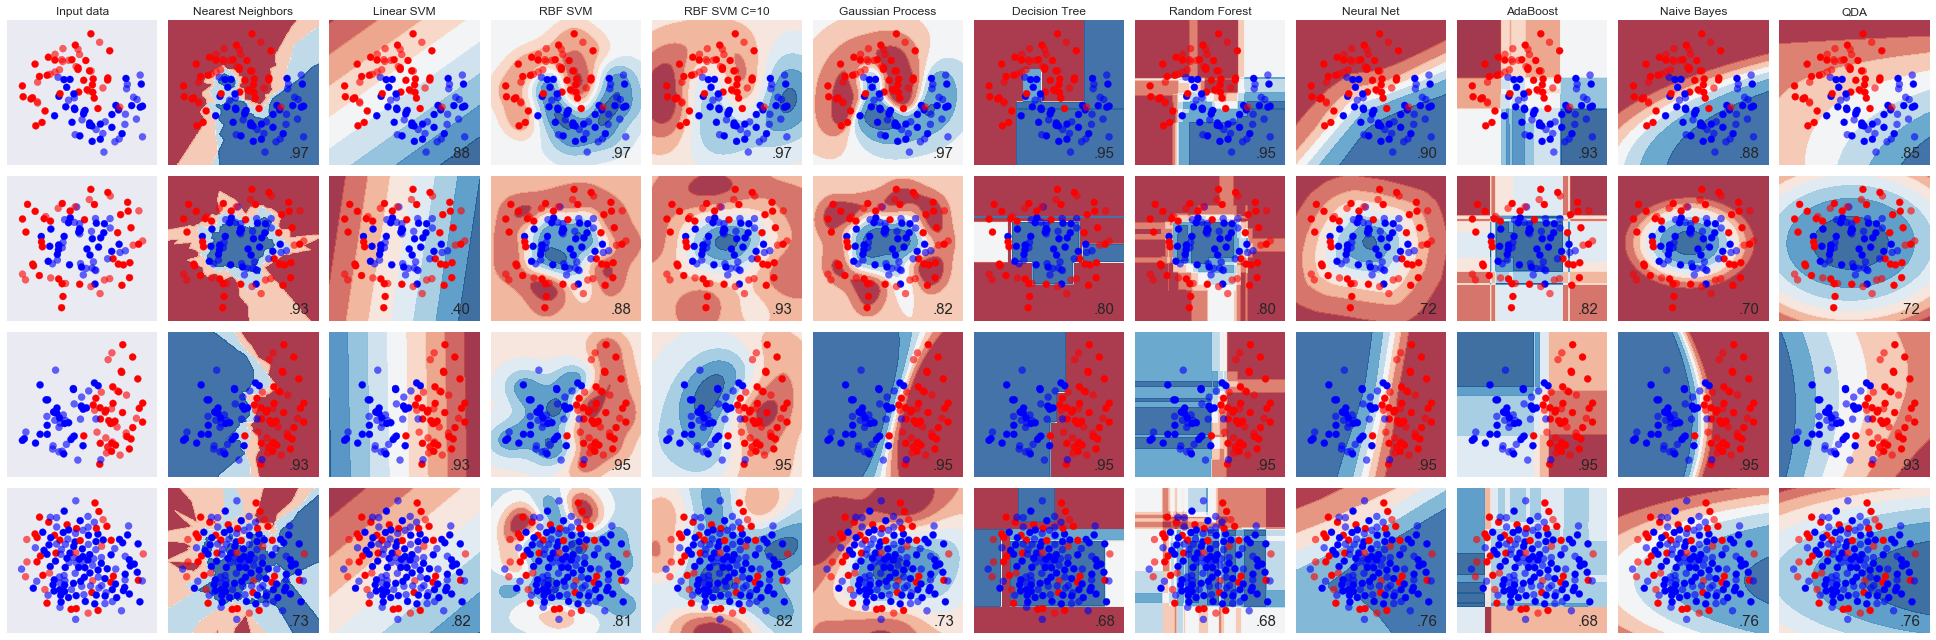

In [310]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "RBF SVM C=10", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    SVC(C=10, kernel='rbf'), 
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable, 
            real_data, 
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()